In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

Enter root folder path containing image subfolders:  Open_eyes_dataset_flat_test
Enter image filename (with extension):  2022-10-17 11:18:10.759307-1977.jpg
Enter crop size in pixels (default=250):  300



Results for 2022-10-17 11:18:10.759307-1977.jpg (left eye), crop=300px:

Mask1: Area=37951, Eccentricity=1.000, TwoRegions=True


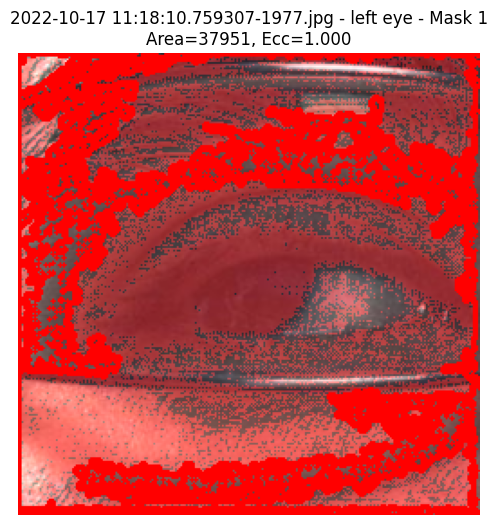

Mask2: Area=6776, Eccentricity=1.000, TwoRegions=True


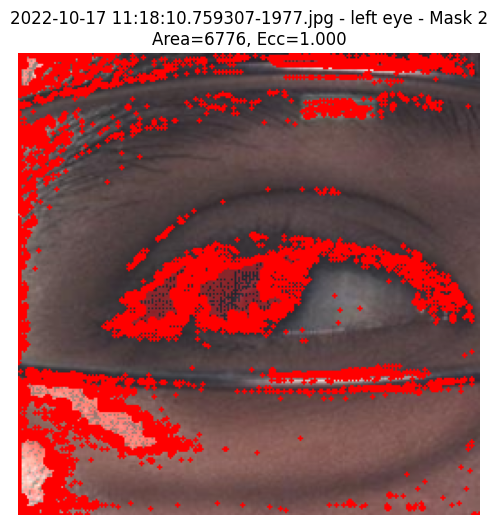

Mask3: Area=1073, Eccentricity=1.000, TwoRegions=True


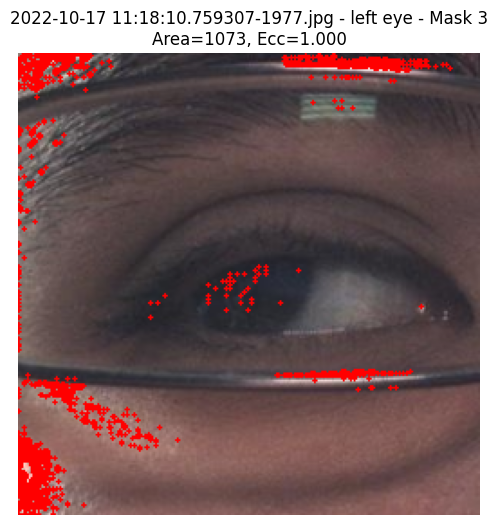


Results for 2022-10-17 11:18:10.759307-1977.jpg (right eye), crop=300px:

Mask1: Area=37106, Eccentricity=1.000, TwoRegions=True


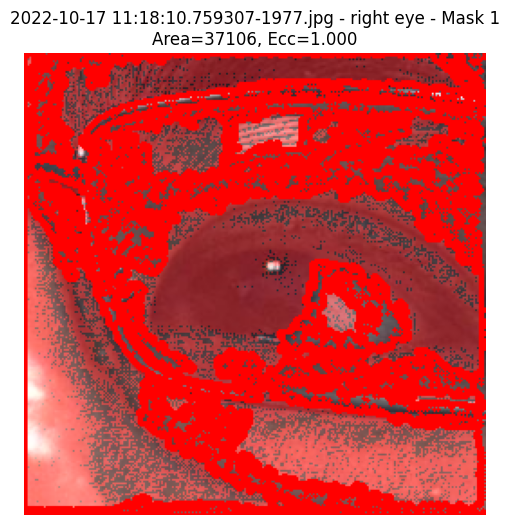

Mask2: Area=7527, Eccentricity=1.000, TwoRegions=True


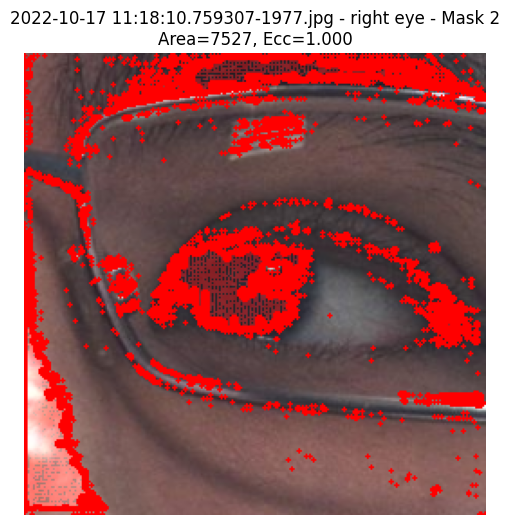

Mask3: Area=1279, Eccentricity=1.000, TwoRegions=True


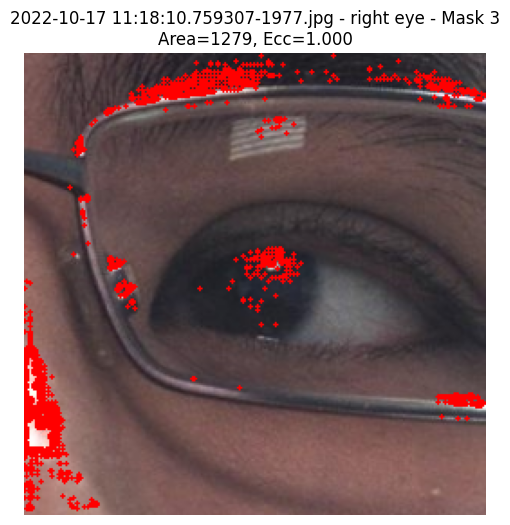

In [12]:


def crop_around_point(image, x, y, crop_size=250):
    """Crop a square patch of size crop_size around (x,y)."""
    h, w, _ = image.shape
    half = crop_size // 2
    x1, x2 = max(0, x-half), min(w, x+half)
    y1, y2 = max(0, y-half), min(h, y+half)
    crop = image[y1:y2, x1:x2]
    # Always resize to 256×256 for U-Net
    crop = cv2.resize(crop, (256, 256))
    return crop



def debug_single_image_unet(root_folder, image_name, csv_path, model, device, crop_size=250):
    coord_df = pd.read_csv(csv_path)
    row = coord_df[coord_df['actual_filename']==image_name]
    if row.empty:
        print(f"ERROR: No CSV entry for {image_name}"); return
    row = row.iloc[0]
    lx,ly = int(row['abs_lx']), int(row['abs_ly'])
    rx,ry = int(row['abs_rx']), int(row['abs_ry'])

    # find image path
    img_path = None
    for sub in os.listdir(root_folder):
        candidate = os.path.join(root_folder,sub,image_name)
        if os.path.isfile(candidate): img_path = candidate; break
    if img_path is None:
        print(f"ERROR: {image_name} not found in {root_folder}"); return

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # crop around both eyes
    crops = [
        crop_around_point(img_rgb, lx, ly, crop_size),
        crop_around_point(img_rgb, rx, ry, crop_size)
    ]


    for i,crop in enumerate(crops):
        eye = "left" if i==0 else "right"
        tensor = torch.from_numpy(crop.transpose(2,0,1)).float().unsqueeze(0)/255.0
        tensor = tensor.to(device)

        with torch.no_grad():
            output = model(tensor)
            mask = torch.sigmoid(output).cpu().numpy()[0,0]

        # try multiple thresholds
        thresholds = [0.5,0.6,0.7,0.8]
        candidate_masks = [(mask>thr).astype(np.uint8) for thr in thresholds]
        top_masks = select_top_masks(candidate_masks, top_k=3)

        print(f"\nResults for {image_name} ({eye} eye), crop={crop_size}px:\n")
        for idx,(mask_,size) in enumerate(top_masks,1):
            ecc = calculate_eccentricity(mask_)
            two = has_two_non_overlapping_regions(mask_)
            print(f"Mask{idx}: Area={size}, Eccentricity={ecc:.3f}, TwoRegions={two}")

            # visualize each mask separately
            overlay = overlay_masks_on_image(crop, [(mask_, size)], alpha=0.4)
            plt.figure(figsize=(6,6))
            plt.imshow(overlay)
            plt.title(f"{image_name} - {eye} eye - Mask {idx}\nArea={size}, Ecc={ecc:.3f}")
            plt.axis('off')
            plt.show()



if __name__=="__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(n_channels=3,n_classes=1).to(device)
    # model.load_state_dict(torch.load("unet_weights.pth", map_location=device))

    root_folder = input("Enter root folder path containing image subfolders: ").strip()
    image_name = input("Enter image filename (with extension): ").strip()
    crop_size = int(input("Enter crop size in pixels (default=250): ") or 250)
    csv_path = "consolidated_coordinates.csv"

    debug_single_image_unet(root_folder, image_name, csv_path, model, device, crop_size)
